In [182]:
import pandas as pd
import re
import nltk
nltk.download("stopwords",  quiet=True)
from nltk.stem.wordnet import WordNetLemmatizer
lema = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [183]:
data = pd.read_csv(".../restaurant.tsv", delimiter="\t")
veri = data.copy()
veri = veri.rename(columns={"Review":"review", "Liked":"liked"})
veri

,review,liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


# PREPROCESSİNG:

In [184]:
after = []
def nlp_preproc(data, column, resub="[^a-zA-Z]", stoplang="english"):
    for i in range(len(data)):
        pre = re.sub(resub, " ", data[column][i])
        pre = pre.lower()
        pre = pre.split()
        pre = [lema.lemmatize(word) for word in pre if not word in set(stopwords.words(stoplang))]
        pre = " ".join(pre)
        after.append(pre)
    befter = pd.DataFrame({"liked":veri["liked"], "review_before":veri[column], "review_after":after})
    return befter

In [185]:
befter = nlp_preproc(veri, column="review")
befter

,liked,review_before,review_after
0,1,Wow... Loved this place.,wow loved place
1,0,Crust is not good.,crust good
2,0,Not tasty and the texture was just nasty.,tasty texture nasty
3,1,Stopped by during the late May bank holiday of...,stopped late may bank holiday rick steve recom...
4,1,The selection on the menu was great and so wer...,selection menu great price
...,...,...,...
995,0,I think food should have flavor and texture an...,think food flavor texture lacking
996,0,Appetite instantly gone.,appetite instantly gone
997,0,Overall I was not impressed and would not go b...,overall impressed would go back
998,0,"The whole experience was underwhelming, and I ...",whole experience underwhelming think go ninja ...


In [186]:
frequency = (befter["review_after"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
frequency.columns = ["words", "frequency"]
frequency

,words,frequency
0,wow,3.0
1,loved,10.0
2,place,111.0
3,crust,2.0
4,good,95.0
...,...,...
1764,ninja,1.0
1765,wasted,1.0
1766,poured,1.0
1767,wound,1.0


# VİSUALİZATİON:

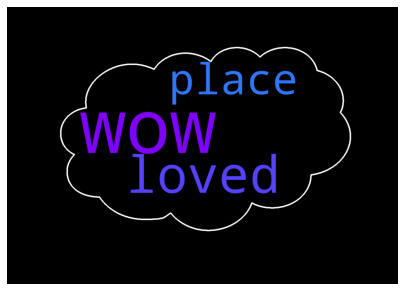

In [187]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# for first sentence:
png = np.array(Image.open(".../cloud.png"))
plt.figure(figsize=(7,7))
cloud = WordCloud(background_color="black", colormap="rainbow", mask=png, contour_width=5, contour_color="white").generate(befter["review_after"][0])
plt.imshow(cloud)
plt.axis("off")
plt.show()

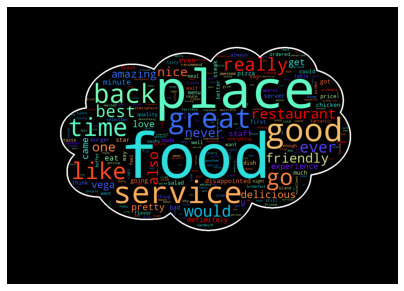

In [188]:
# for all data with frequencies:
wordict = dict(frequency.values)
png = np.array(Image.open(".../cloud.png"))
plt.figure(figsize=(7,7))
cloud = WordCloud(background_color="black", colormap="rainbow", mask=png, contour_width=5, max_words=250, contour_color="white").generate_from_frequencies(wordict)
plt.imshow(cloud)
plt.axis("off")
plt.show()

# MODELLING:

In [189]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer for 500 words:
cv = CountVectorizer(max_features=500)
matrix = cv.fit_transform(after).toarray()
matrixdf = pd.DataFrame(matrix, columns = cv.get_feature_names_out())
matrixdf

,absolutely,ago,also,although,always,amazing,ambiance,ambience,amount,another,...,worse,worst,worth,would,wow,wrong,year,yet,yummy,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
# y(independent variable) must be array
# matrix is x(dependent variables)
y = veri.iloc[:,1].values

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(matrix, y, test_size = 0.2, random_state=9)

In [192]:
# MODELLING WITH GAUSSİANNB:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
score*100

69.5

In [193]:
# MODELLING WITH RANDOM FOREST:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=9)
modelrf.fit(X_train, y_train)
predrf = modelrf.predict(X_test)
scorerf = accuracy_score(y_test, predrf)
scorerf*100

70.0

In [194]:
# MODELLING WITH LOGISTIC REGRESSION:
from sklearn.linear_model import LogisticRegression

modellg = LogisticRegression(random_state=9)
modellg.fit(X_train, y_train)
predlg = modellg.predict(X_test)
scorelg = accuracy_score(y_test, predlg)
scorelg*100

75.0